In [24]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
import pandas as pd


resol = 300
pi = np.pi
version_table()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

<h1> RG Scheme </h1>

In [2]:
def update_state(c,b,gamma,omega_tab,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k, 0>
    b (float): Atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix_individual = 1j * np.sqrt(gamma / (2*L)) * np.exp(-1j * (omega_tab - omega_A) * t)
    g_matrix = np.concatenate((g_matrix_individual, g_matrix_individual))

    b_new = c @ g_matrix
    c_new = b * np.conjugate(g_matrix)

    return -1j* dt * c_new, -1j * dt * b_new

def RG_scheme(c_init, b_init, gamma, omega_tab, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k, 0>
    b_init (float): initial atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(c_init)//2
    c_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)
    b_array = np.zeros(nb_pts_time, dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b_array[0] = b_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b_current = b_array[i-1]

        c_new_k1, b_new_k1 = update_state(c_current, b_current, gamma, omega_tab, omega_A, L, t, dt)
        c_new_k2, b_new_k2 = update_state(c_current + c_new_k1/2, b_current + b_new_k1/2, gamma, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k3, b_new_k3 = update_state(c_current + c_new_k2/2, b_current + b_new_k2/2, gamma, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k4, b_new_k4 = update_state(c_current + c_new_k3, b_current + b_new_k3, gamma, omega_tab, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b_new = b_current + (b_new_k1 + 2*b_new_k2 + 2*b_new_k3 + b_new_k4) / 6

        c_array[i] = c_new
        b_array[i] = b_new

    return c_array, b_array 
    

<h1> Function that treats the whole evolution </h1>

In [109]:
def get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, delta_k, x_0, print_nb_modes = False, progress_bar=True):
    """
    Generate data for the RG scheme with a mirror.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k, 0>.
    b_array (np array): Coefficients in front of the state |0, 1>.
    omega_tab (np array): Array of frequencies.
    """
    
    #quantization of the modes
    omega_tab_individual = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_individual)
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    #print("Preparing the initial state...")
    c_init = np.zeros(2*n_modes, dtype=complex)
    b_init = 0

    c_init_1 = np.exp(-(k_tab_individual - omega_0)**2 /(4*delta_k**2)) * np.exp(-1j * k_tab_individual * x_0)
    c_init = np.concatenate((c_init_1, np.zeros(n_modes))) #only one photon in the first channel
    c_init /= np.sqrt(np.sum(np.abs(c_init)**2))  # Normalize the initial state

    ##evolve the state
    #print("Evolving the state...")
    c_array, b_array = RG_scheme(c_init, b_init, gamma, omega_tab_individual, omega_A, L, T, dt, progress_bar=progress_bar)


    return c_array, b_array, k_tab_individual

###For comparison with ED

def get_data_mirror_ed(L, T, dt, omega_0, omega_A, omega_max, gamma, delta_k, x_0, print_nb_modes = False):
    #quantization of the modes
    omega_tab_individual = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_individual)
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = 2*n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    for i in range(n_modes):

        #diagonal elements
        H_matrix[i, i] = omega_tab_individual[i]
        H_matrix[i+n_modes, i+n_modes] = omega_tab_individual[i]

        #off diagonal elements
        H_matrix[2*n_modes,i] = 1j*np.sqrt(gamma/(2*L))
        H_matrix[2*n_modes, i+n_modes] = 1j*np.sqrt(gamma/(2*L))

        H_matrix[i,2*n_modes] = -1j*np.sqrt(gamma/(2*L))
        H_matrix[i+n_modes, 2*n_modes] = -1j*np.sqrt(gamma/(2*L))

    H_matrix[2*n_modes, 2*n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None

    print("Initializing the state ...")
    ##Initial state

    init_state = 0
    for i in range(n_modes): ##only the modes in the first waveguide
        coef = np.exp(-(k_tab_individual[i] - omega_0)**2 / (4*delta_k**2)) *np.exp(-1j * k_tab_individual[i] * x_0)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states
    
    return times, state_list

<h1> First test </h1>

Generate an example

In [250]:
L = 50*pi
T = L/2
dt = 0.01

#Bare parameters
gamma = 1
omega_A = 10
omega_max = 20

#renormalized parameters
prefactor = 1/(1-gamma/(2*pi)*(1/omega_A + 1/(omega_max - omega_A)))
omega_A_phys = omega_A - gamma / (2*pi) * np.log((omega_max-omega_A)/omega_A) * prefactor
gamma_phys = gamma * prefactor


#initial photonic wave packet
omega_0 = omega_A_phys 
x_0 = -L/4

#delta_x = L/(8 * np.sqrt(2))
#delta_x = L/8
delta_k = 0.05*gamma
delta_x = 1/(2*delta_k)



#check some parameters
print("50% Reflectivity for omega_0_m = ", omega_A_phys - gamma, " and omega_0_p = ", omega_A_phys + gamma)
print("Value of gamma", gamma, "and sigma_momentum = ", delta_k)
print("Delta_x / (L/2) = ", delta_x / (L/2))

#save the parameters
save_param = True

if save_param:
    data = {
        'L' : L,
        'gamma': gamma,
        'dt': dt,
        'omega_A': omega_A,
        'omega_0': omega_0,
        'omega_max': omega_max,
        'delta_k': delta_k
    }
    df = pd.DataFrame(data, index=[0])
    current_filename = f"single_photon_example_param.csv"
    df.to_csv(current_filename, index=False)

50% Reflectivity for omega_0_m =  9.0  and omega_0_p =  11.0
Value of gamma 1 and sigma_momentum =  0.05
Delta_x / (L/2) =  0.12732395447351627


In [14]:
recover_example = True

if recover_example:
    param_file = f"single_photon_example_param.csv"
    df = pd.read_csv(param_file)

    L = df['L'][0]
    T = L/2
    dt = df['dt'][0]
    omega_0 = df['omega_0'][0]
    omega_A = df['omega_A'][0]
    omega_max = df['omega_max'][0]
    gamma = df['gamma'][0]
    delta_k = df['delta_k'][0]
    x_0 = -L/4

c_array, b_array, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, delta_k, x_0, print_nb_modes=True)

#ED comparision
ed = True

if ed:
    dt_ed = 0.01
    print("Exact diagonalization...")
    times_ed, state_list_ed = get_data_mirror_ed(L, T, dt, omega_0, omega_A, omega_max, gamma, delta_k, x_0, print_nb_modes = True)

Number of modes:  501
Preparing the initial state...
Evolving the state...


  0%|          | 0/7852 [00:00<?, ?it/s]

Exact diagonalization...
Number of modes:  501
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   0.38s. Est. time left: 00:00:00:03
20.0%. Run time:   0.67s. Est. time left: 00:00:00:02
30.0%. Run time:   0.97s. Est. time left: 00:00:00:02
40.0%. Run time:   1.28s. Est. time left: 00:00:00:01
50.0%. Run time:   1.51s. Est. time left: 00:00:00:01
60.0%. Run time:   1.75s. Est. time left: 00:00:00:01
70.0%. Run time:   1.98s. Est. time left: 00:00:00:00
80.0%. Run time:   2.20s. Est. time left: 00:00:00:00
90.0%. Run time:   2.42s. Est. time left: 00:00:00:00
100.0%. Run time:   2.64s. Est. time left: 00:00:00:00
Total run time:   2.64s


<h1> Occupation numbers </h1>

In [15]:
time_array = np.linspace(0, T, int(T / dt))
# Prepare the k_tab for occupation numbers
n_modes = c_array.shape[1] //2
nb_pts_time = int(T / dt)

p_1 = np.zeros(nb_pts_time)
p_2 = np.zeros(nb_pts_time)
p_atom =  np.zeros(nb_pts_time)

for i in tqdm(range(nb_pts_time)):
    p_1[i] = np.sum(np.abs(c_array[i,:n_modes])**2)
    p_2[i] = np.sum(np.abs(c_array[i,n_modes:])**2)
    p_atom[i] = np.abs(b_array[i])**2  

#comparing with ed
if ed:
    nb_pts_time_ed = len(times_ed)
    p_1_ed = np.zeros(nb_pts_time_ed)
    p_2_ed = np.zeros(nb_pts_time_ed)
    p_atom_ed =  np.zeros(nb_pts_time_ed)

    for i in tqdm(range(nb_pts_time_ed)):
        current_state = state_list_ed[i].full().reshape(2*n_modes+1)
        p_1_ed[i] = np.sum(np.abs(current_state[:n_modes]**2))
        p_2_ed[i] = np.sum(np.abs(current_state[n_modes:2*n_modes]**2))
        p_atom_ed[i] = np.abs(current_state[2*n_modes]**2)    
    

  0%|          | 0/7853 [00:00<?, ?it/s]

  0%|          | 0/7853 [00:00<?, ?it/s]

Reflection probability = 0.9907820569774144
Final atom's excitation probability:  8.553902454278006e-05


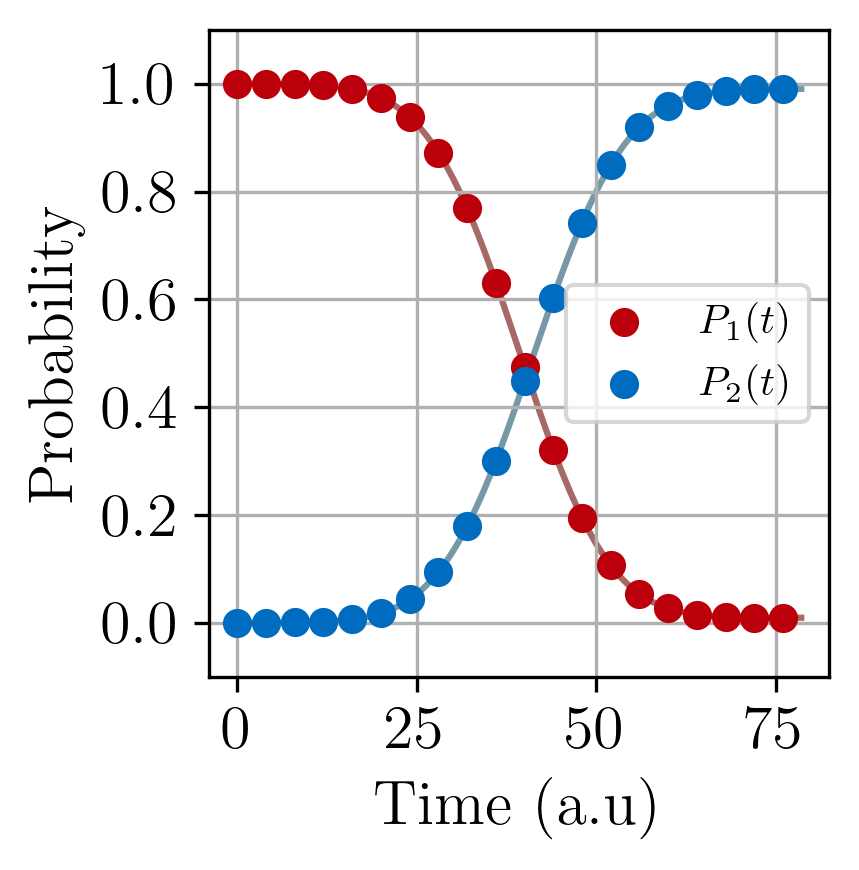

In [26]:
print("Reflection probability =", 1-p_1[-1])
print("Final atom's excitation probability: ", 1-p_1[-1]-p_2[-1])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

step_to_show = 400

ax.scatter(time_array[::step_to_show], p_1[::step_to_show], label=r'$P_1(t)$', color='#bb000b', zorder = 1)
ax.scatter(time_array[::step_to_show], p_2[::step_to_show], label=r'$P_2(t)$', color='#006cbf', zorder=1)

if ed:
    ax.plot(times_ed, p_1_ed, color='#6d0303', alpha=0.6, zorder = -1)
    ax.plot(times_ed, p_2_ed,color='#1c556d', alpha=0.6, zorder = -1)

ax.set_xlabel('Time (a.u)')
ax.set_ylabel('Probability')
ax.set_ylim(-0.1,1.1)
ax.legend(prop={'size': 10})

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


ax.grid()
ax.set_axisbelow(True)  

plt.tight_layout()
plt.savefig("./fig/one_photon_ex_p1p2.pdf")
plt.show()

/var/folders/ds/7w970h197d59hh_2dj4ry5qw0000gn/T/ipykernel_1608/3101998640.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


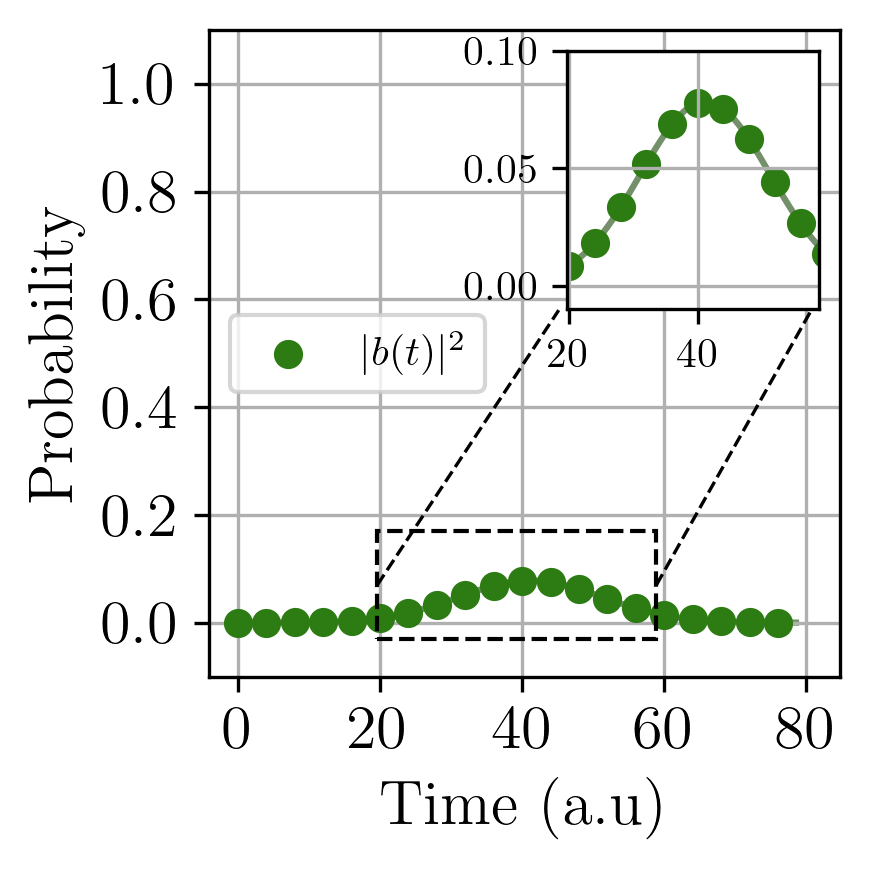

In [27]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

step_to_show = 400
ax.scatter(time_array[::step_to_show], p_atom[::step_to_show], label=r'$|b(t)|^2$', color='#2c7b13')   

if ed:
    ax.plot(times_ed, p_atom_ed,color='#174708', alpha=0.6, zorder=-1) 


#ax.set_ylim(-0.1,1.1)
ax.set_xlabel('Time (a.u)')
ax.set_ylabel('Probability')

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


ax.grid()
ax.set_axisbelow(True)  
ax.set_ylim(-0.1,1.1)


# Create an inset axes [x0, y0, width, height] in axes coordinates
axins = inset_axes(ax, width="40%", height="40%", loc='upper right')

# Zoom range near zero
axins.scatter(time_array[::step_to_show], p_atom[::step_to_show], color='#2c7b13')   
axins.plot(times_ed, p_atom_ed,color='#174708', alpha=0.6, zorder=-1) 
axins.set_xlim(L/8, 3*L/8)
axins.set_ylim(-0.01, 0.1)  # slightly higher for clarity
axins.grid()

rect = Rectangle((L/8, -0.03), L/4, 0.2, linewidth=1, edgecolor='black', linestyle='--', facecolor='none')
ax.add_patch(rect)
ax.plot([L/8, 1.15*L/4], [0.07, 0.58], '--', color='black', lw=0.8)
ax.plot([3*L/8, 1.37*3*L/8], [0.07, 0.58], '--', color='black', lw=0.8)

ax.legend(prop={'size': 10}, loc="center left")

plt.tight_layout()
plt.savefig("./fig/one_photon_ex_b.pdf")
plt.show()

<h1> Reflection against detunning </h1>

In [ ]:
param_file = f"single_photon_example_param.csv"
df = pd.read_csv(param_file)

L = df['L'][0]
T = L/2
dt = df['dt'][0]
omega_A = df['omega_A'][0]
gamma = df['gamma'][0]
delta_k = df['delta_k'][0]
x_0 = -L/4

nb_freq = 19
omega_0_tab = np.linspace(omega_A - gamma, omega_A + gamma, nb_freq)
omega_max_tab = np.array([2*omega_A, 3*omega_A, 4*omega_A])
reflection_tab = np.zeros((nb_freq,len(omega_max_tab)))

for i in tqdm(range(nb_freq)):
    omega_0 = omega_0_tab[i]
    for j in range(len(omega_max_tab)):
        omega_max = omega_max_tab[j]
        c_array, b_array, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, delta_k, x_0, print_nb_modes=False, progress_bar=False)
        p_1_final = np.sum(np.abs(c_array[-1,:len(k_tab)])**2)
        reflection_tab[i,j] = 1 - p_1_final

#save the result
save_reflection = True
if save_reflection:
    data = {
        'omega_0_tab': omega_0_tab,
        'reflection_2omegaA': reflection_tab[:,0],
        'reflection_3omegaA': reflection_tab[:,1],
        'reflection_4omegaA': reflection_tab[:,2]
    }
    df = pd.DataFrame(data)
    current_filename = f"single_photon_reflection_multi_UV_cutoff.csv"
    df.to_csv(current_filename, index=False)


  0%|          | 0/19 [00:00<?, ?it/s]

Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the st

Recover the results and plot

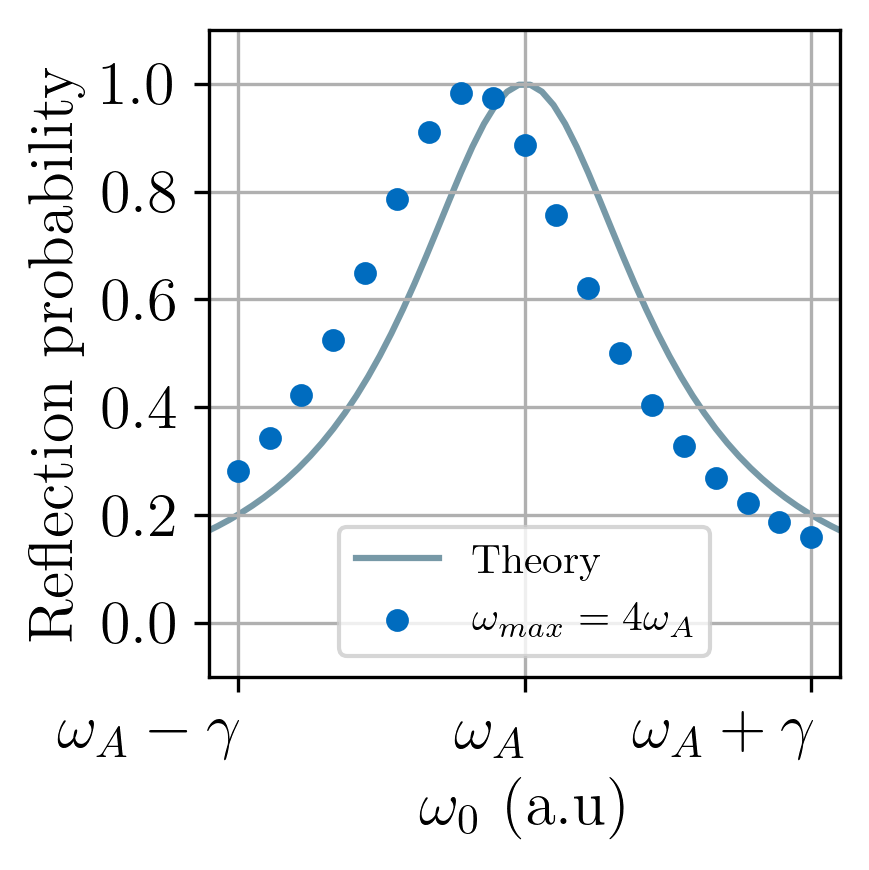

In [ ]:
#parameters
param_file = f"single_photon_example_param.csv"
df = pd.read_csv(param_file)


omega_A = df['omega_A'][0]
gamma = df['gamma'][0]

#Recover the reflection results
file_reflection = f"single_photon_reflection_multi_UV_cutoff.csv"
df = pd.read_csv(file_reflection)

omega_0_tab_theory = np.linspace(omega_A - 2*gamma, omega_A + 2*gamma, 100)
theory = 1 / (1 + ((omega_0_tab_theory - omega_A)/ (gamma/2))**2)

UV_str = "4omegaA"

omega_0_tab = df['omega_0_tab'].values
reflection_to_show = df['reflection_'+UV_str+''].values

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(omega_0_tab_theory, theory, label='Theory', color='#1c556d', alpha=0.6, zorder = -1)
ax.scatter(omega_0_tab, reflection_to_show, label=r'$\omega_{max} = 4 \omega_A$', color='#006cbf', s=20)

ax.set_xlabel(r'$\omega_0$ (a.u)')
ax.set_xticks([omega_A - 2*gamma, omega_A - gamma, omega_A, omega_A + gamma, omega_A + 2*gamma])
ax.set_xticklabels([r'$\omega_A - 2\gamma$', r'$\omega_A - \gamma$', r'$\omega_A$', r'$\omega_A + \gamma$', r'$\omega_A + 2\gamma$'])
#rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
#set x limits
ax.set_xlim(omega_A - 1.1*gamma, omega_A + 1.1*gamma)

ax.set_ylabel('Reflection probability')
ax.set_ylim(-0.1,1.1)

ax.legend(prop={'size': 10}, loc="lower center")

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


ax.grid()
ax.set_axisbelow(True)  

fig.tight_layout()
#plt.savefig("./fig/reflection_UV_"+UV_str+".pdf")
plt.show()

<h1> Check frequency shift </h1>

In [49]:
param_file = f"single_photon_example_param.csv"
df = pd.read_csv(param_file)

L = df['L'][0]
T = L/2
dt = df['dt'][0]
omega_A = df['omega_A'][0]
gamma = df['gamma'][0]
delta_k = df['delta_k'][0]
x_0 = -L/4

omega_0 = omega_A
nb_UV = 30
omega_max_tab = np.linspace(2*omega_A, 50*omega_A, nb_UV)
reflection_tab = np.zeros(nb_UV)

for i in tqdm(range(nb_UV)):
    omega_max = omega_max_tab[i]
    c_array, b_array, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, delta_k, x_0, print_nb_modes=False, progress_bar=False)
    p_1_final = np.sum(np.abs(c_array[-1,:len(k_tab)])**2)
    reflection_tab[i] = 1 - p_1_final

#save the result
save_reflection = True
if save_reflection:
    data = {
        'omega_max_tab': omega_max_tab,
        'reflection': reflection_tab
    }
    df = pd.DataFrame(data)
    current_filename = f"single_photon_reflection_UV_cutoff_dependence.csv"
    df.to_csv(current_filename, index=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the st

Recover the results and plot

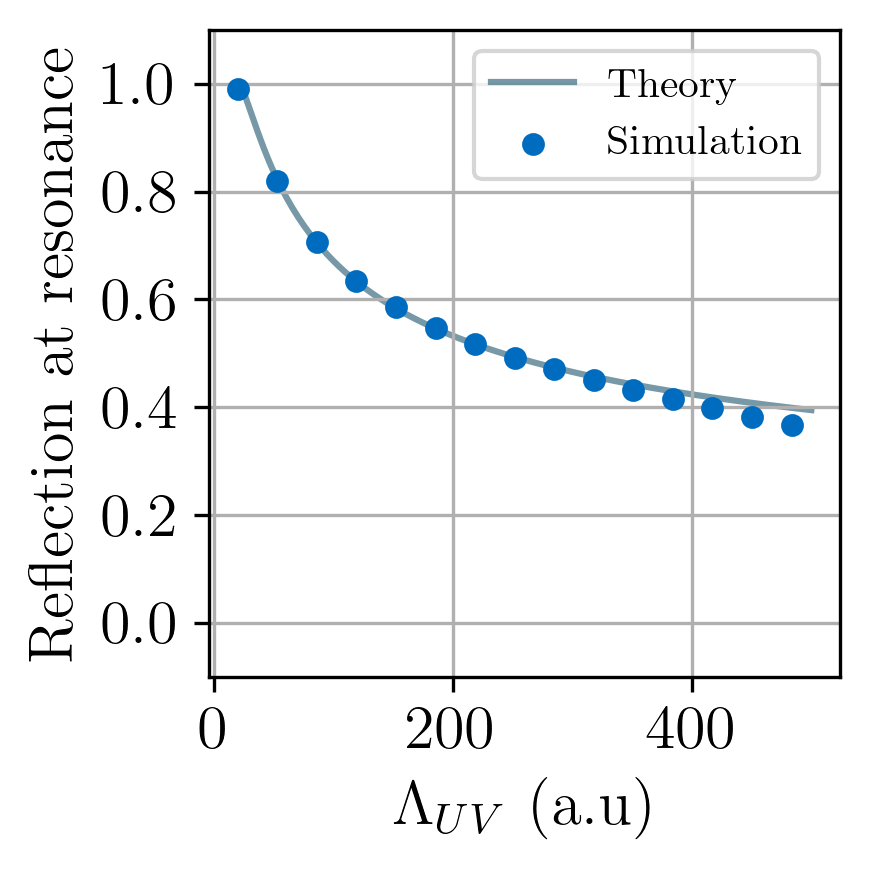

In [65]:
param_file = f"single_photon_example_param.csv"
df = pd.read_csv(param_file)

omega_A = df['omega_A'][0]
gamma = df['gamma'][0]


data_file = f"single_photon_reflection_UV_cutoff_dependence.csv"
df = pd.read_csv(data_file)
omega_max_tab = df['omega_max_tab'].values
reflection_tab = df['reflection'].values

#theoretical curve
omega_max_tab_theory = np.linspace(2*omega_A, 50*omega_A, 200)

#prefactor = 1/(1-gamma/(2*pi)*(1/omega_A + 1/(omega_max_tab_theory - omega_A)))
prefactor = 1
gamma_phys_tab = gamma*prefactor
omega_A_phys_tab = omega_A - gamma / (2*pi) * np.log(np.abs(omega_max_tab_theory - omega_A) / omega_A) * prefactor

reflection_tab_theory = 1 / (1 + (omega_A - omega_A_phys_tab)**2 / (gamma/2)**2)

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

step_to_show = 2
ax.plot(omega_max_tab_theory, reflection_tab_theory, label='Theory', color='#1c556d', alpha=0.6, zorder = -1)
ax.scatter(omega_max_tab[::step_to_show], reflection_tab[::step_to_show], label='Simulation ', color='#006cbf', s=20)


ax.set_xlabel(r'$\Lambda_{UV}$ (a.u)')
ax.set_ylabel(r'Reflection at resonance')
ax.set_ylim(-0.1,1.1)

ax.legend(prop={'size': 10})

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


ax.grid()
ax.set_axisbelow(True)  

fig.tight_layout()
plt.savefig("./fig/reflection_UV_dependence.pdf")
plt.show()

<h1> Second check : get the frequency explicitely </h1>

In [78]:
param_file = f"single_photon_example_param.csv"
df = pd.read_csv(param_file)

L = df['L'][0]
T = L/2
dt = df['dt'][0]
omega_A = df['omega_A'][0]
gamma = df['gamma'][0]
delta_k = df['delta_k'][0]
x_0 = -L/4

nb_freq_omega_0 = 29
nb_UV = 19
omega_0_tab = np.linspace(omega_A - gamma, omega_A + gamma, nb_freq_omega_0)
omega_max_tab = np.linspace(2*omega_A, 50*omega_A, nb_UV)

omega_A_phys_tab = np.zeros(nb_UV)


for i in tqdm(range(nb_UV)):
    omega_max = omega_max_tab[i]
    #get the reflection against omega_0
    reflection_tab = np.zeros(nb_freq_omega_0)
    for j in range(nb_freq_omega_0):
        c_array, b_array, k_tab = get_data_mirror_fast(L, T, dt, omega_0_tab[j], omega_A, omega_max, gamma, delta_k, x_0, print_nb_modes=False, progress_bar=False)
        p_1_final = np.sum(np.abs(c_array[-1,:len(k_tab)])**2)
        reflection_tab[j] = 1 - p_1_final

    omega_A_phys_tab[i] = omega_0_tab[np.argmin(np.abs(reflection_tab - 1))]

#save the result
save_reflection = True
if save_reflection:
    data = {
        'omega_max_tab': omega_max_tab,
        'omega_A_phys_tab': omega_A_phys_tab
    }
    df = pd.DataFrame(data)
    current_filename = f"single_photon_reflection_omegaA_vs_UV_cutoff.csv"
    df.to_csv(current_filename, index=False)

  0%|          | 0/19 [00:00<?, ?it/s]

Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the st

Recover the results and plot

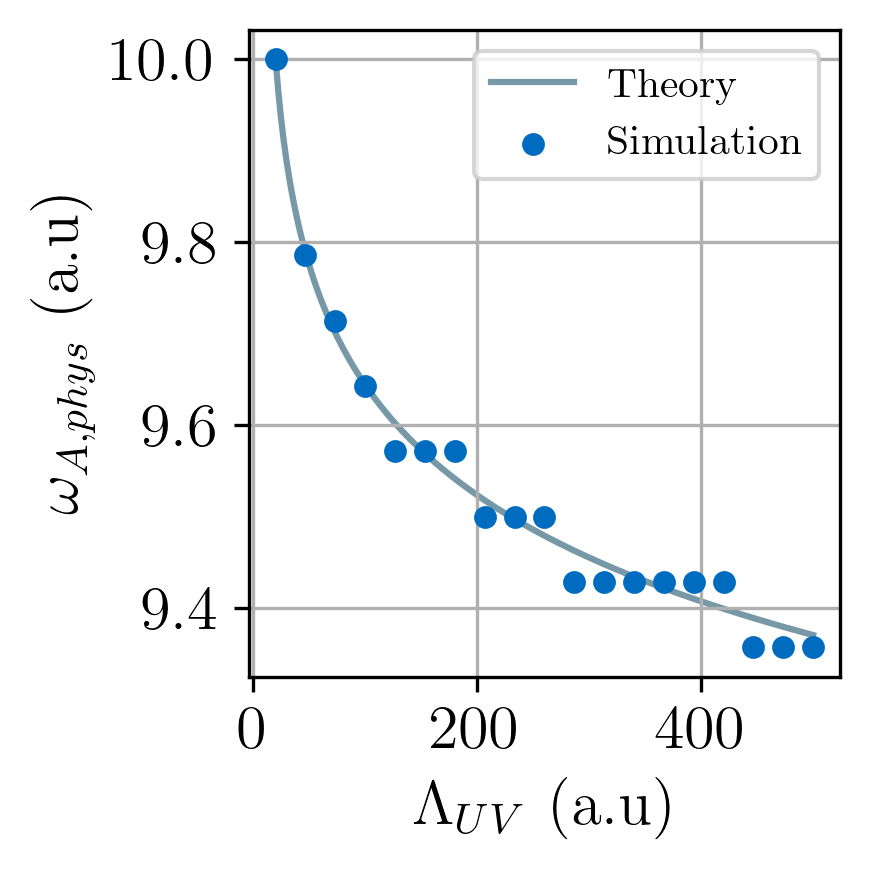

In [79]:
param_file = f"single_photon_example_param.csv"
df = pd.read_csv(param_file)

omega_A = df['omega_A'][0]
gamma = df['gamma'][0]

data_file = f"single_photon_reflection_omegaA_vs_UV_cutoff.csv"
df = pd.read_csv(data_file)
omega_max_tab = df['omega_max_tab'].values
omega_A_phys_tab = df['omega_A_phys_tab'].values

#theoretical curve
omega_max_tab_theory = np.linspace(2*omega_A, 50*omega_A, 200)

prefactor = 1/(1-gamma/(2*pi)*(1/omega_A + 1/(omega_max_tab_theory - omega_A)))
#prefactor = 1
omega_A_phys_tab_theory = omega_A - gamma / (2*pi) * np.log(np.abs(omega_max_tab_theory - omega_A) / omega_A) * prefactor

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(omega_max_tab_theory, omega_A_phys_tab_theory, label='Theory', color='#1c556d', alpha=0.6, zorder = -1)
ax.scatter(omega_max_tab, omega_A_phys_tab, label='Simulation ', color='#006cbf', s=20)
ax.set_xlabel(r'$\Lambda_{UV}$ (a.u)')
ax.set_ylabel(r'$\omega_{A,phys}$ (a.u)')
ax.legend(prop={'size': 10}) 

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax.grid()
ax.set_axisbelow(True)

fig.tight_layout()
#plt.savefig("./fig/omegaA_phys_vs_UV_cutoff.pdf")
plt.show()

<h1> Renormalization decay rate </h1>

In [ ]:
param_file = f"single_photon_example_param.csv"
df = pd.read_csv(param_file)

L = df['L'][0]
T = L/2
dt = df['dt'][0]
omega_A = df['omega_A'][0]
omega_max = df['omega_max'][0]
delta_k = df['delta_k'][0]
x_0 = -L/4

nb_freq = 19
gamma_tab = np.array([1, 3, 5])
reflection_tab = np.zeros((nb_freq,len(gamma_tab)))

for j in range(len(gamma_tab)):
    gamma = gamma_tab[j]
    omega_0_tab = np.linspace(omega_A - gamma, omega_A + gamma, nb_freq)
    for i in tqdm(range(nb_freq)):
        omega_0 = omega_0_tab[i]
        c_array, b_array, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, delta_k, x_0, print_nb_modes=False, progress_bar=False)
        p_1_final = np.sum(np.abs(c_array[-1,:len(k_tab)])**2)
        reflection_tab[i,j] = 1 - p_1_final

#save the result
save_reflection = True
if save_reflection:
    data = {
        'reflection_1gamma': reflection_tab[:,0],
        'reflection_3gamma': reflection_tab[:,1],
        'reflection_5gamma': reflection_tab[:,2]
    }
    df = pd.DataFrame(data)
    current_filename = f"single_photon_reflection_multi_gamma.csv"
    df.to_csv(current_filename, index=False)


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Recover and plot

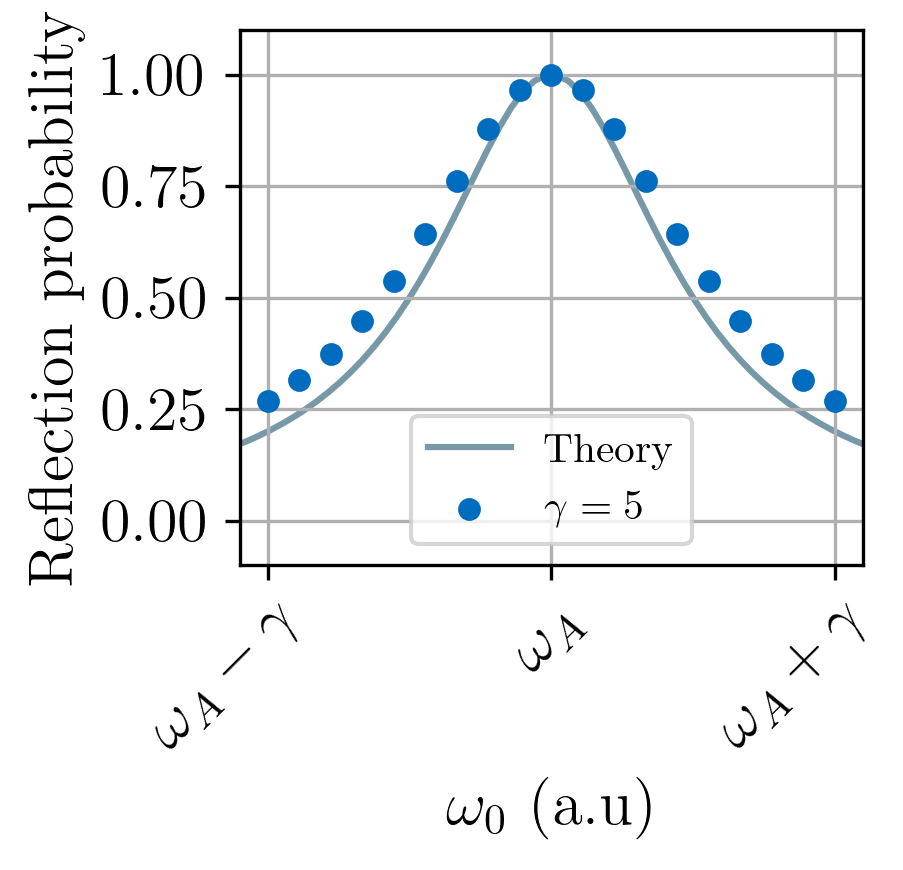

In [127]:
#parameters
param_file = f"single_photon_example_param.csv"
df = pd.read_csv(param_file)

omega_A = df['omega_A'][0]


#Recover the reflection results
file_reflection = f"single_photon_reflection_multi_gamma.csv"
df = pd.read_csv(file_reflection)
gamma_str = "5gamma"
gamma = 5

omega_0_tab_theory = np.linspace(omega_A - 2*gamma, omega_A + 2*gamma, 100)
theory = 1 / (1 + ((omega_0_tab_theory - omega_A)/ (gamma/2))**2)

reflection_to_show = df['reflection_'+gamma_str+''].values
nb_freq = len(reflection_to_show)
omega_0_tab = np.linspace(omega_A - gamma, omega_A + gamma, nb_freq)

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(omega_0_tab_theory, theory, label='Theory', color='#1c556d', alpha=0.6, zorder = -1)
ax.scatter(omega_0_tab, reflection_to_show, label=r'$\gamma = 5$', color='#006cbf', s=20)

ax.set_xlabel(r'$\omega_0$ (a.u)')
ax.set_xticks([omega_A - 2*gamma, omega_A - gamma, omega_A, omega_A + gamma, omega_A + 2*gamma])
ax.set_xticklabels([r'$\omega_A - 2\gamma$', r'$\omega_A - \gamma$', r'$\omega_A$', r'$\omega_A + \gamma$', r'$\omega_A + 2\gamma$'])
#rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
#set x limits
ax.set_xlim(omega_A - 1.1*gamma, omega_A + 1.1*gamma)

ax.set_ylabel('Reflection probability')
ax.set_ylim(-0.1,1.1)

ax.legend(prop={'size': 10}, loc="lower center")

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


ax.grid()
ax.set_axisbelow(True)  

fig.tight_layout()
plt.savefig("./fig/reflection_gamma_"+gamma_str+".pdf")
plt.show()